## Team 4

## Name:

Yu-Chih (Wisdom) Chen

Jessy Hu

Boya Zeng

Yuqing Wu

## Date:

02/10/2024

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
from functools import reduce
import warnings
warnings.filterwarnings('ignore')
import random

In [2]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 8


In [3]:
pandarallel.initialize(nb_workers=num_processors-3, use_memory_fs=False)

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Load Instacart Dataset

In [4]:
%%time
df = pd.read_csv("instacart.csv")
df.head(3)

CPU times: user 16.3 s, sys: 4.87 s, total: 21.2 s
Wall time: 23 s


order_id  product_id  add_to_cart_order  reordered        product_name  \
0         2       33120                  1          1  Organic Egg Whites   
1        26       33120                  5          0  Organic Egg Whites   
2       120       33120                 13          0  Organic Egg Whites   

   aisle_id  department_id  user_id eval_set  order_number  order_dow  \
0        86             16   202279    prior             3          5   
1        86             16   153404    prior             2          0   
2        86             16    23750    prior            11          6   

   order_hour_of_day  days_since_prior_order aisle  department  
0                  9                     8.0  eggs  dairy eggs  
1                 16                     7.0  eggs  dairy eggs  
2                  8                    10.0  eggs  dairy eggs

### 1.1 Structure of data

In [5]:
df_records_1 = df.shape[0]
df_fields_1 = df.shape[1]
print("There are totally %d records and %d fields in record" %(df_records_1,df_fields_1))

There are totally 32434489 records and 15 fields in record


1) There are totally 32,434,489 records and 29 fields in the dataframe

In [6]:
# All operations based on raw data will be performed on df_0
df_0 = copy.deepcopy(df)

In [7]:
df_0['order_id'] = df_0['order_id'].astype('object')
df_0['user_id'] = df_0['user_id'].astype('object')
df_0['product_id'] = df_0['product_id'].astype('object')
df_0['aisle_id'] = df_0['aisle_id'].astype('object')
df_0['department_id'] = df_0['department_id'].astype('object')

In [8]:
feature_types = set()

# Features Category Analysis
for column in tqdm(df_0.columns.values):
  print(column,"\t", df_0[column].dtype)
  feature_types.add(str(df_0[column].dtype))
print("feature type: ", feature_types)

100%|████████████████████████████████████████| 15/15 [00:00<00:00, 18131.00it/s]

order_id 	 object
product_id 	 object
add_to_cart_order 	 int64
reordered 	 int64
product_name 	 object
aisle_id 	 object
department_id 	 object
user_id 	 object
eval_set 	 object
order_number 	 int64
order_dow 	 int64
order_hour_of_day 	 int64
days_since_prior_order 	 float64
aisle 	 object
department 	 object
feature type:  {'float64', 'object', 'int64'}


In [9]:
# Check Missing Value

df_0.isnull().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
product_name                    0
aisle_id                        0
department_id                   0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
aisle                           0
department                      0
dtype: int64

In [10]:
## Observing the input data, we have missing values,
## which are not shown in the statistical analysis.
## Therefore, we replace the missing value "" with np.nan
## and re-compute the statistical data.

for column in tqdm(df_0.columns.values):
    df_0[column] = df_0[column].parallel_map(lambda x: np.nan if x == '' else x)

100%|███████████████████████████████████████████| 15/15 [00:28<00:00,  1.88s/it]


In [11]:
df_0.isnull().sum()/df_0.shape[0]*100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
aisle                     0.00000
department                0.00000
dtype: float64

We can classify the features into **float64**, **object** and **int** according to the dtype of the column elements.

In [12]:
# Feature Statistical Analysis
float_feat = []
object_feat = []
int_feat = []

for column in tqdm(df_0.columns.values):
  if df_0[column].dtype == "float64":
    float_feat.append(column)
  elif df_0[column].dtype == "object":
    object_feat.append(column)
  else:
    int_feat.append(column)

100%|████████████████████████████████████████| 15/15 [00:00<00:00, 69136.88it/s]


In [13]:
float_feat

['days_since_prior_order']

In [14]:
object_feat

['product_name', 'eval_set', 'aisle', 'department']

In [15]:
int_feat

['order_id',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'aisle_id',
 'department_id',
 'user_id',
 'order_number',
 'order_dow',
 'order_hour_of_day']

Based on specific meanings of the features, we could divide the features into 'numerical', 'categorical' and 'empty' features:

1. **Numerical features**: order_dow, order_hour_of_day, days_since_prior, reordered

2. **Categorical features**:

*   **Nominal features**: order_id, user_id, eval_set, product_id, product_name, aisle_id, aisle, department_id, department
*   **Ordinal features**: order_number, add_to_cart_order

3. **Empty features**: days_since_prior

### 1.2 Additional basic summary statistics

#### 1.2.1 Numerical Feature Analysis

In [16]:
numerical_feat = ['order_dow', 'order_hour_of_day', 'days_since_prior_order', 'reordered']

stat_df = df_0.loc[:,numerical_feat]
stat_df.describe()

order_dow  order_hour_of_day  days_since_prior_order     reordered
count  3.243449e+07       3.243449e+07            3.035642e+07  3.243449e+07
mean   2.738818e+00       1.342498e+01            1.110407e+01  5.896975e-01
std    2.090049e+00       4.246365e+00            8.778914e+00  4.918886e-01
min    0.000000e+00       0.000000e+00            0.000000e+00  0.000000e+00
25%    1.000000e+00       1.000000e+01            5.000000e+00  0.000000e+00
50%    3.000000e+00       1.300000e+01            8.000000e+00  1.000000e+00
75%    5.000000e+00       1.600000e+01            1.500000e+01  1.000000e+00
max    6.000000e+00       2.300000e+01            3.000000e+01  1.000000e+00

#### 1.2.2 Categorical Feature Analysis

In [17]:
%%time

# Your existing code
nominal_col = ['order_id', 'user_id', 'eval_set', 
               'product_id', 'product_name', 'aisle_id', 
               'aisle', 'department_id', 'department']

df_0_null = pd.DataFrame(df_0.isnull().sum())
df_0_uni = pd.DataFrame(df_0.nunique())

dfs = [df_0_null, df_0_uni]
df_0_s = reduce(lambda df_left,df_right: pd.merge(df_left,df_right,left_index=True,right_index=True,how='outer'),dfs)
df_0_s.columns = ["Count_of_Nulls","Unique_Value"]
df_0_s.transpose().loc[:,object_feat].transpose()

CPU times: user 6.67 s, sys: 733 ms, total: 7.4 s
Wall time: 7.52 s


Count_of_Nulls  Unique_Value
product_name               0         49677
eval_set                   0             1
aisle                      0           134
department                 0            21

# Customer Segmentation

In [19]:
#Aggregated purchase data by customer and aisle using cross tab

cust_prod = pd.crosstab(df_0['user_id'], df_0['aisle'])
cust_prod.head(10)

aisle    air fresheners candles  asian foods  baby accessories  \
user_id                                                          
1                             0            0                 0   
2                             0            3                 0   
3                             0            0                 0   
4                             0            0                 0   
5                             0            2                 0   
6                             0            0                 0   
7                             0            0                 0   
8                             0            1                 0   
9                             0            0                 0   
10                            0            1                 0   

aisle    baby bath body care  baby food formula  bakery desserts  \
user_id                                                            
1                          0                  0                0   
2                          0                  0                0   
3                          0                  0                0   
4                          0                  0                0   
5                          0                  0                0   
6                          0                  0                0   
7                          0                  0                0   
8                          0                  0                0   
9                          0                  6                0   
10                         0                  0                0   

aisle    baking ingredients  baking supplies decor  beauty  beers coolers  \
user_id                                                                     
1                         0                      0       0              0   
2                         2                      0       0              0   
3                         0                      0       0              0   
4                         0                      0       0              0   
5                         0                      0       0              0   
6                         0                      0       0              0   
7                         2                      0       0              0   
8                         1                      0       0              0   
9                         2                      0       0              0   
10                        0                      0       0              0   

aisle    ...  spreads  tea  tofu meat alternatives  tortillas flat bread  \
user_id  ...                                                               
1        ...        1    0                       0                     0   
2        ...        3    1                       1                     0   
3        ...        4    1                       0                     0   
4        ...        0    0                       0                     1   
5        ...        0    0                       0                     0   
6        ...        0    0                       0                     0   
7        ...        0    0                       0                     0   
8        ...        0    0                       0                     0   
9        ...        0    0                       0                     0   
10       ...        0    0                       0                     0   

aisle    trail mix snack mix  trash bags liners  vitamins supplements  \
user_id                                                                 
1                          0                  0                     0   
2                          0                  0                     0   
3                          0                  0                     0   
4                          0                  0                     0   
5                          0                  0                     0   
6                          0             

In [20]:
cust_prod.columns

Index(['air fresheners candles', 'asian foods', 'baby accessories',
       'baby bath body care', 'baby food formula', 'bakery desserts',
       'baking ingredients', 'baking supplies decor', 'beauty',
       'beers coolers',
       ...
       'spreads', 'tea', 'tofu meat alternatives', 'tortillas flat bread',
       'trail mix snack mix', 'trash bags liners', 'vitamins supplements',
       'water seltzer sparkling water', 'white wines', 'yogurt'],
      dtype='object', name='aisle', length=134)

In [ ]:
# Perfom PCA to reduce dimension
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
def standardize(df):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df)
    
    
    return scaled
scaled=standardize(cust_prod)

pca = PCA()
pca.fit(scaled)

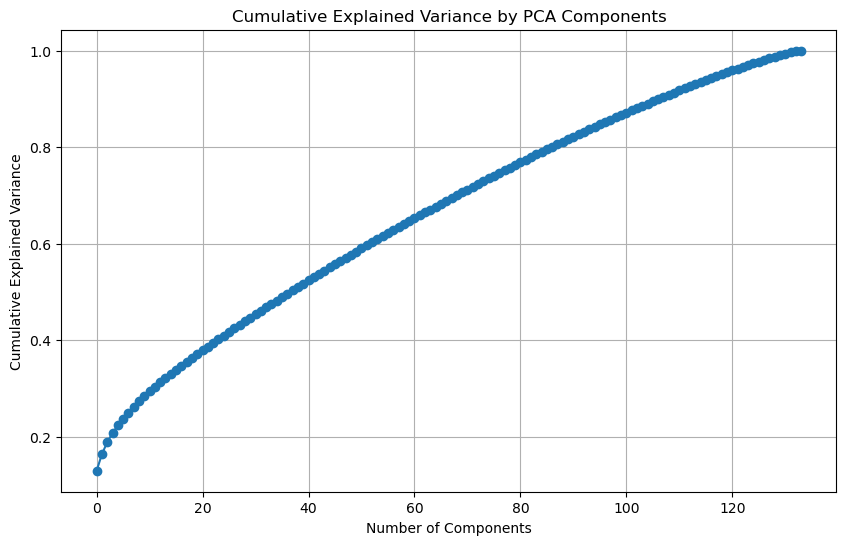

78

In [22]:
# Cumulative explained variance ratio
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

cumulative_explained_variance
# Selecting the number of components to explain at least 75% of the variance
target_variance = 0.75
num_components = sum(cumulative_explained_variance < target_variance) + 1

num_components

In [23]:
pca = PCA(n_components=num_components)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

(206209, 2)
          4          1
0  0.269042   2.429427
1 -6.920938  36.751116
2 -0.442368   2.404383
3 -0.288232  -0.755823
4  0.612825  -2.637225


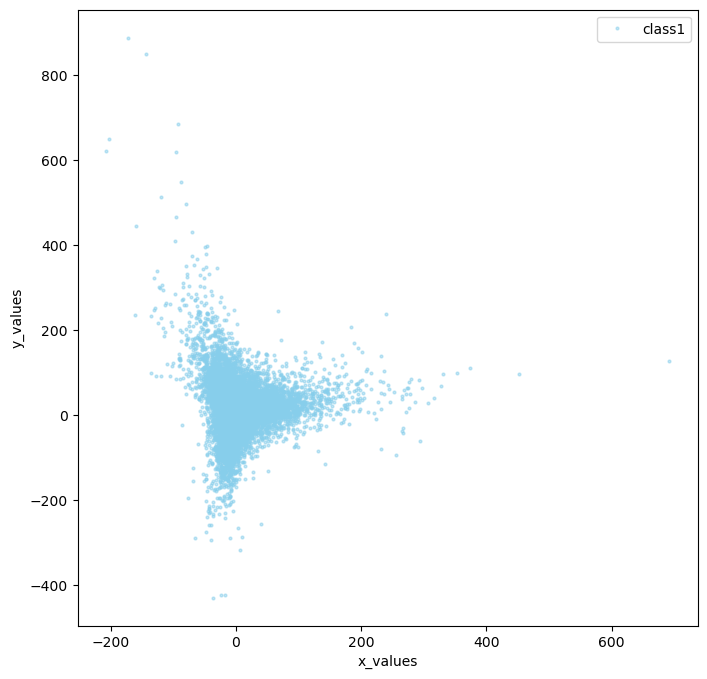

In [24]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
ps = pd.DataFrame(pca_samples)


tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='skyblue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

<Axes: title={'center': 'The elbow method'}, xlabel='Number of clusters', ylabel='Inertia'>

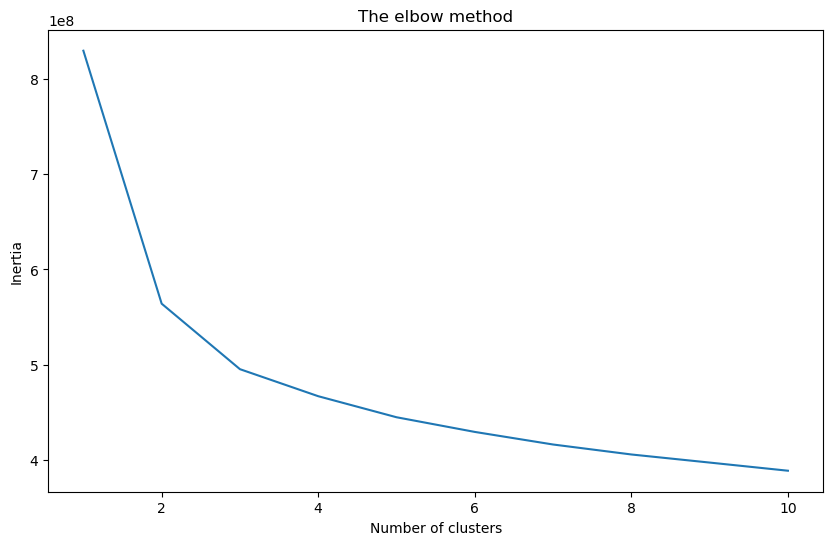

In [27]:
# Perform elbow method and silhouette score analysis to choose optimal k

from sklearn.cluster import KMeans

def plot_inertia(array, start=1, end=10):

    inertia = []
    for k in range(start,end+1):
        model = KMeans(n_clusters=k,n_init=10,random_state=0)
        model.fit(array)
        inertia.append(model.inertia_)
    x_axis=range(start,end+1)

    fig, ax = plt.subplots(figsize=(10,6))

    ax.set_title('The elbow method')
    ax.set_ylabel('Inertia')
    ax.set_xlabel('Number of clusters')
    plt.plot(x_axis, inertia)


    return ax

plot_inertia(ps)

In [28]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for n_cluster in tqdm(range(2, 7)):
    kmeans = KMeans(n_clusters=n_cluster, random_state=0,n_init=10)
    cluster_labels = kmeans.fit_predict(ps.iloc[:, 1:10])
    silhouette_avg = silhouette_score(ps.iloc[:, 1:10], cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_cluster}, the average silhouette_score is : {silhouette_avg}")




 20%|████████▊                                   | 1/5 [05:33<22:15, 333.87s/it]

For n_clusters = 2, the average silhouette_score is : 0.6997841538995956


 40%|█████████████████▌                          | 2/5 [11:15<16:55, 338.39s/it]

For n_clusters = 3, the average silhouette_score is : 0.5505786123616186


 60%|██████████████████████████▍                 | 3/5 [16:51<11:14, 337.41s/it]

For n_clusters = 4, the average silhouette_score is : 0.5638229476778281


 80%|███████████████████████████████████▏        | 4/5 [23:37<06:04, 364.41s/it]

For n_clusters = 5, the average silhouette_score is : 0.5649666425116353


100%|████████████████████████████████████████████| 5/5 [30:01<00:00, 360.33s/it]

For n_clusters = 6, the average silhouette_score is : 0.5562093614579218


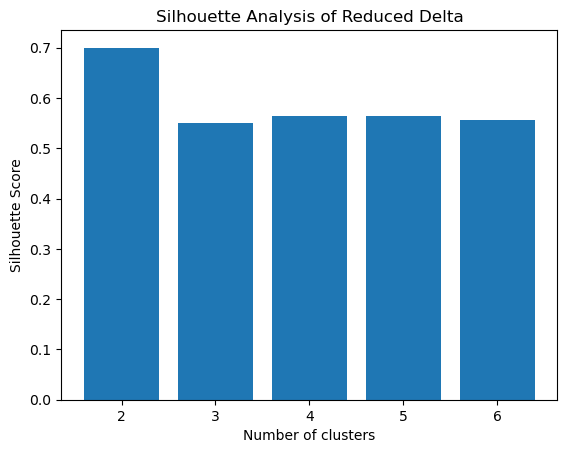

In [29]:
# Plotting a bar graph to compare the results
plt.bar(range(2, 7), silhouette_scores)
plt.title('Silhouette Analysis of Reduced Delta')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

## we will choose k=4 here. although k=2 seems to be the optimal, but there will be less information. k=5 will have the second largest silhoutte score, but after we plot it out, we see one of the cluster is too small to compare. therefore, we utimately chose k=4

In [30]:
# choose n_cluster=4
clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ -4.71201841 -40.617772  ]
 [ -0.11856333   0.09813797]
 [-11.27561288  65.26938505]
 [ 76.8233881   26.26358548]]


['blue', 'black', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']


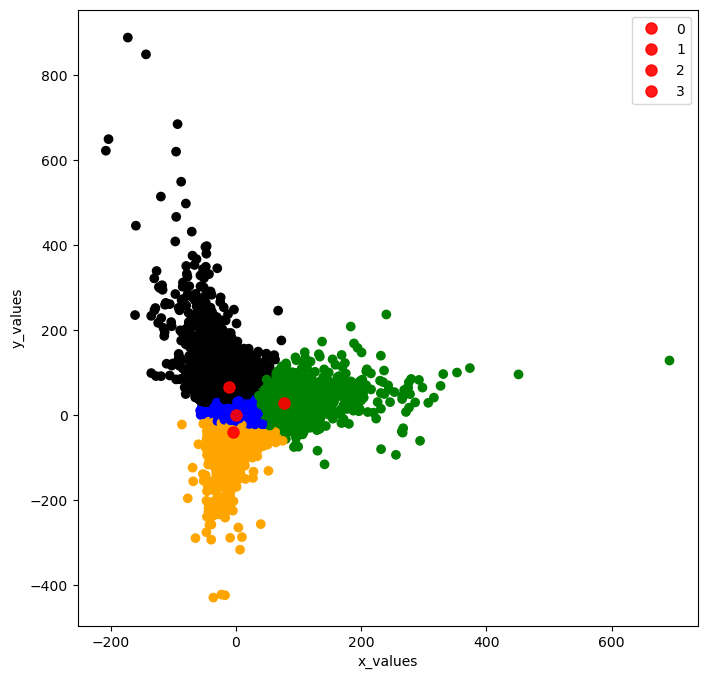

In [31]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','black','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()


In [32]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle    air fresheners candles  asian foods  baby accessories  \
user_id                                                          
1                             0            0                 0   
2                             0            3                 0   
3                             0            0                 0   
4                             0            0                 0   
5                             0            2                 0   
6                             0            0                 0   
7                             0            0                 0   
8                             0            1                 0   
9                             0            0                 0   
10                            0            1                 0   

aisle    baby bath body care  baby food formula  bakery desserts  \
user_id                                                            
1                          0                  0                0   
2                          0                  0                0   
3                          0                  0                0   
4                          0                  0                0   
5                          0                  0                0   
6                          0                  0                0   
7                          0                  0                0   
8                          0                  0                0   
9                          0                  6                0   
10                         0                  0                0   

aisle    baking ingredients  baking supplies decor  beauty  beers coolers  \
user_id                                                                     
1                         0                      0       0              0   
2                         2                      0       0              0   
3                         0                      0       0              0   
4                         0                      0       0              0   
5                         0                      0       0              0   
6                         0                      0       0              0   
7                         2                      0       0              0   
8                         1                      0       0              0   
9                         2                      0       0              0   
10                        0                      0       0              0   

aisle    ...  tea  tofu meat alternatives  tortillas flat bread  \
user_id  ...                                                      
1        ...    0                       0                     0   
2        ...    1                       1                     0   
3        ...    1                       0                     0   
4        ...    0                       0                     1   
5        ...    0                       0                     0   
6        ...    0                       0                     0   
7        ...    0                       0                     0   
8        ...    0                       0                     0   
9        ...    0                       0                     0   
10       ...    0                       0                     0   

aisle    trail mix snack mix  trash bags liners  vitamins supplements  \
user_id                                                                 
1                          0                  0                     0   
2                          0                  0                     0   
3                          0                  0                     0   
4                          0                  0                     0   
5                          0                  0                     0   
6                          0                  0                     0   
7                          0                  0                     0   
8  

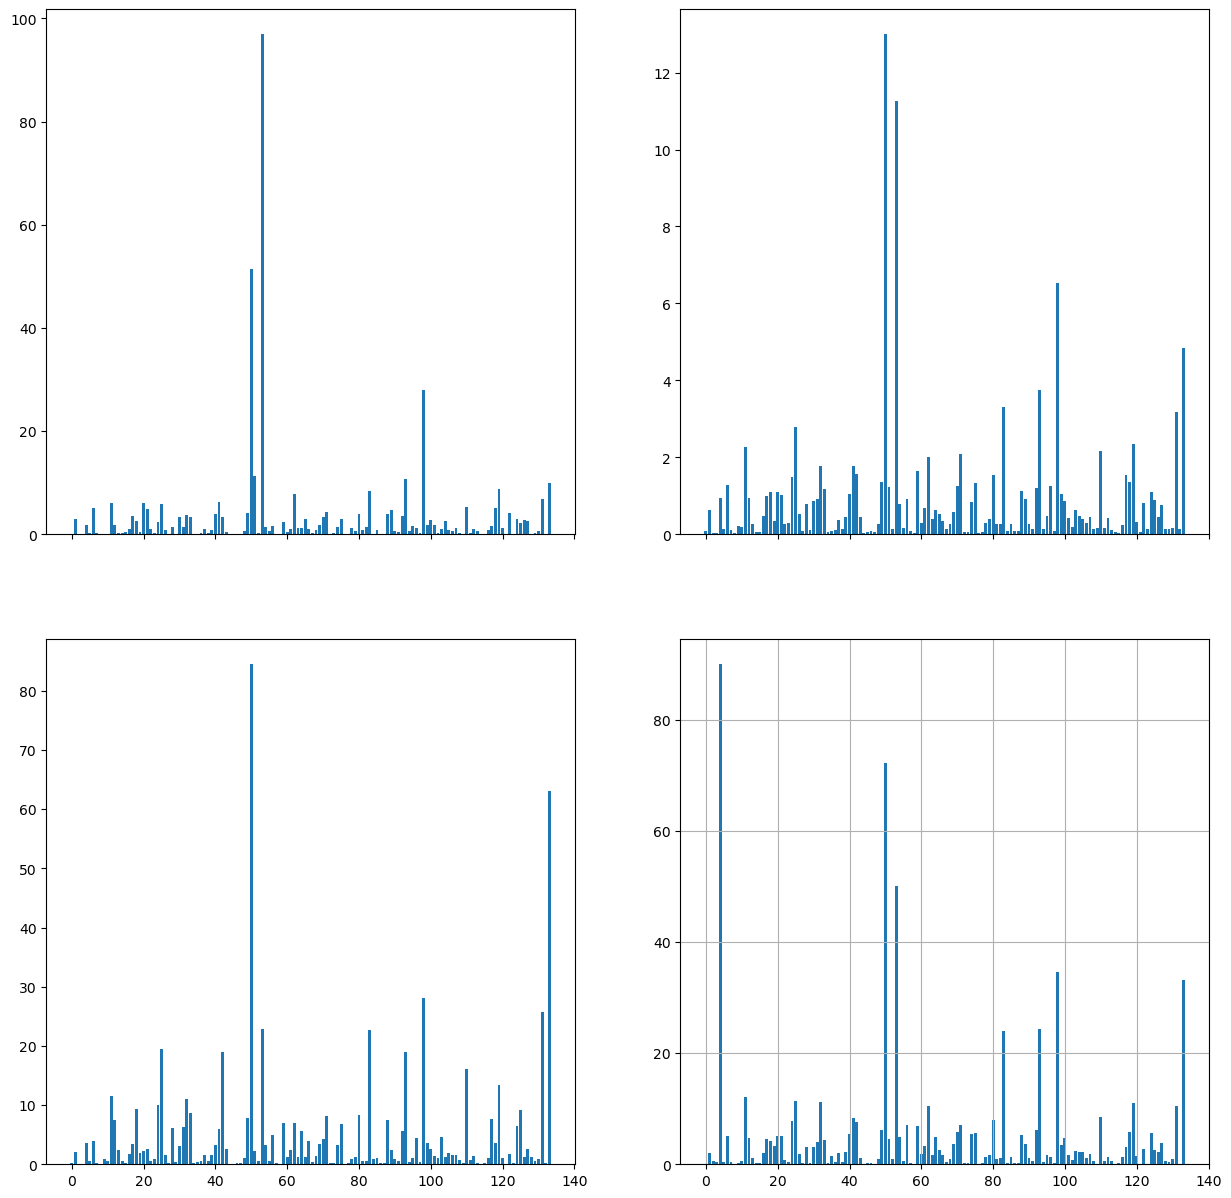

In [33]:
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
arr[0,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
arr[0,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)
c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
plt.grid()
plt.show()




## To see what is top 5 most frequently bought by each cluster

In [35]:
c0.sort_values(ascending=False)[0:5]

aisle
fresh vegetables              96.918109
fresh fruits                  51.413042
packaged vegetables fruits    27.918020
fresh herbs                   11.316262
packaged cheese               10.643825
dtype: float64

In [36]:
c1.sort_values(ascending=False)[0:5]

aisle
fresh fruits                  12.996364
fresh vegetables              11.262384
packaged vegetables fruits     6.531656
yogurt                         4.839576
packaged cheese                3.754687
dtype: float64

In [37]:
c2.sort_values(ascending=False)[0:5]

aisle
fresh fruits                     84.496210
yogurt                           63.002190
packaged vegetables fruits       28.143675
water seltzer sparkling water    25.790130
fresh vegetables                 22.901129
dtype: float64

In [38]:
c3.sort_values(ascending=False)[0:5]

aisle
baby food formula             90.031453
fresh fruits                  72.334056
fresh vegetables              50.059111
packaged vegetables fruits    34.557484
yogurt                        33.242950
dtype: float64

## compare to 3 other cluster, cluster 3 have different purchase behaviour --> they bought alot baby food formula. Therefore raised our interest of further analysis.

In [39]:
clust_prod[clust_prod['cluster']==0].shape,clust_prod[clust_prod['cluster']==1].shape,clust_prod[clust_prod['cluster']==2].shape,clust_prod[clust_prod['cluster']==3].shape

((11149, 135), (187279, 135), (5937, 135), (1844, 135))

In [40]:
cluster_3_df=clust_prod[clust_prod['cluster']==3]
interested_user_ids=pd.array(cluster_3_df.index)
baby_formula_df=df[df['user_id'].isin(interested_user_ids)]


In [41]:
baby_formula_df.shape

(1233644, 15)

In [42]:
baby_formula_df.head(10)

order_id  product_id  add_to_cart_order  reordered  \
57       7518       33120                  6          1   
58       7518       32655                 13          1   
78      10977       33120                  6          1   
92      13215       33120                 13          1   
119     16825       33120                  1          0   
124     17731       33120                  1          1   
125     17731       14218                  4          1   
152     20556       33120                 20          0   
240     31365       33120                 14          1   
241     31365       23543                 15          1   

                             product_name  aisle_id  department_id  user_id  \
57                     Organic Egg Whites        86             16    74197   
58      Organic Large Grade AA Brown Eggs        86             16    74197   
78                     Organic Egg Whites        86             16    74197   
92                     Organic Egg Whites        86             16   107592   
119                    Organic Egg Whites        86             16    82364   
124                    Organic Egg Whites        86             16   140299   
125  Grade A Large Eggs Cage Free Omega 3        86             16   140299   
152                    Organic Egg Whites        86             16    13701   
240                    Organic Egg Whites        86             16   152544   
241        Organic Extra Large Brown Eggs        86             16   152544   

    eval_set  order_number  order_dow  order_hour_of_day  \
57     prior             9          3                 18   
58     prior             9          3                 18   
78     prior            38          6                 12   
92     prior            27          2                 14   
119    prior            13          6                  8   
124    prior             4          2                  8   
125    prior             4          2                  8   
152    prior            88          4                 12   
240    prior            31          4                 14   
241    prior            31          4                 14   

     days_since_prior_order aisle  department  
57                     10.0  eggs  dairy eggs  
58                     10.0  eggs  dairy eggs  
78                      6.0  eggs  dairy eggs  
92                      9.0  eggs  dairy eggs  
119                    15.0  eggs  dairy eggs  
124                     8.0  eggs  dairy eggs  
125                     8.0  eggs  dairy eggs  
152                     3.0  eggs  dairy eggs  
240                     7.0  eggs  dairy eggs  
241                     7.0  eggs  dairy eggs